# Jongjun Park from McMaster Univ.
## Discovering Relations within Multi-Stream IoT Datasets

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# read data in CSV
df = pd.read_csv('/Users/jongjunPark/Research-timeSeries/Dataset/Energy/PAN_DB/PANDB.csv')

In [2]:
## Data pre-processing
### Original data 'PANDB' contains 309 sensors' readings, but the duration is different
### In here, we only try to investgate longer (more than 1000) readings with similar time duration
### Moreover, the original data only have 'minute' based recordings (without hour and day)

In [3]:
# Re-arrange time-domain: Originally, mm-ss (there is no exact hour representation)

# set min and sec with hours (+60 when hour was changed)
df['Time_min'] = df.Time.str.split(':').str[0]
df['Time_min'] = pd.to_numeric(df['Time_min'])

# add 60 to next hour (Time stamp did not have any of data and hour records)
i=0
for i in range(len(df)-1) :
    if df['Time_min'][i] > df['Time_min'][i+1] :
        #display('iter', i)
        df['Time_min'][i+1:] += 60

# Extract the 'name' which contains location and sensor type
# So each 'name' indicates independently recorded data
df_name = df.drop_duplicates(["Name"])
df_name.reset_index(drop=True, inplace=True) # re-indexing each data frame (of sensors)

# Find the sub-set which has records at the same time
# in here, we only extract the data at the first 24-hours of data

training_hour = 24 # define

df_sample = df_name[df_name['Time_min'] < 120] # we only consider samples which has first 2-hours (120 min) data
df_sample.reset_index(drop=True, inplace=True)

# if recorded data of 'sensor' is less than threshold, delete them in the candidate list
# In here, we define the treshold_len as the 1st sensor's number of records within the training_hour 
tmp = df[df['Name'] == df_sample['Name'][0]]
threshold_len = len(tmp[tmp['Time_min'] < training_hour*60]) # get 24(training_hour)-hours data to train

add_val = np.empty(len(df_sample), dtype=object)
for i in range(len(df_sample)) :
    tmp = df[df['Name'] == df_sample['Name'][i]]
    # if the length of data is less than 24-hours, we drop it
    if len(tmp) < threshold_len :
        #print('i=', i)
        #tmp.info()
        df_sample = df_sample.drop(i)
    else :
        add_val[i] = len(tmp)
    
add_val = list(filter(None, add_val))

# add Number of values in the column
df_sample['Num_Value'] = add_val
df_sample.reset_index(drop=True, inplace=True)

# Make sample data as dataframe
# Set Time_min to index
# Each column is Values by Name

# Find all recorded Time (if there is no record, we set nan)
df_time = df.drop_duplicates(["Time_min"])
df_time.reset_index(drop=True, inplace=True) # re-indexing each data frame (of sensors)

# Set 'Time_min' index
df_time.set_index('Time_min', drop=False, append=True, inplace=True)
df_time.rename(columns={'Time_min':'T'}, inplace=True)
# Delete the data
df_use1 = df_time.drop(['Time', 'Name', 'Bldg', '_Value', 'MeasureName'], axis=1)

# Fill in the 'values' in df_use with 'Time_min' index
for i in range(len(df_sample)) :
    tmp = df[df['Name'] == df_sample['Name'][i]] # read data
    tmp.set_index('Time_min', drop=True, append=True, inplace=True) # change index to 'Time_min'
    tmp2 = tmp.drop(['Time', 'Name', 'Bldg', 'MeasureName'], axis=1) # Delete all except '_Value'
    txt_str = df_sample['Name'][i] # Rename '_Value' to sensor name
    tmp2.columns = [txt_str.replace(" ","")]
    df_use1 = pd.merge(df_use1, tmp2, how='outer', on='Time_min') # Merge the data with index ('Time_min')

# df_use1 contains NaN values

# (1) Jist fill in the NaN with the previous value => Consider real-time
#df_use.fillna(method='ffill', inplace=True)
#df_use.fillna(method='bfill', inplace=True) # only 1st line

# (2) Fill in the NaN with linear interpolation
df_use = df_use1.interpolate(method='linear', limit_direction='forward')
df_use.fillna(method='bfill', inplace=True) # only 1st line

<ipython-input-3-9e8235d3a15e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_min'][i+1:] += 60
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [4]:
# Calculate the Pearson Correlations
# learning period set

# round_sample = 0: use original value
# round_sample = 1: use round value without sampling
# round_sample from 0.1 to 0.9: random sampling with the percentages
def setPCC(round_sample):
    df_corr = df_use[df_use['T']<60*training_hour]
    df_corr.drop(['T'], inplace=True, axis=1)
    
    # rounding
    if round_sample == 0:        
        df_corr_sample = df_corr        
    else :
        df_round = round(df_corr*2) / 2 # rounding -> increase the resolution by unit 0.5
        if round_sample < 1:
            df_round_sample = df_round.sample(frac = round_sample) # use only round_sample * 100 %
            df_corr_sample = df_round_sample.sort_index()
        elif round_sample == 1:
            df_corr_sample = df_round
        else :
            return 0 # invalid input
        
    heatmap = df_corr_sample.corr(method='pearson')    
    heatmap.fillna(0, inplace=True)


    # plot sample
    f = plt.figure(figsize=(20,16))
    plt.matshow(abs(heatmap), fignum=f.number)
    plt.xticks(range(df_corr_sample.select_dtypes(['number']).shape[1]), df_corr_sample.select_dtypes(['number']).columns, fontsize=16, rotation=45)
    plt.yticks(range(df_corr_sample.select_dtypes(['number']).shape[1]), df_corr_sample.select_dtypes(['number']).columns, fontsize=16)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)
    plt.title('Correlation Matrix', fontsize=20);

    return heatmap, df_corr_sample



In [13]:
# Apply Gaussian Process here
# We only uses the cluster values
# In this case, each sensor values would be calculated with the other members'
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# set observation, two days here, 
# In here, estimate the 1st ([0]) value in the cluster 1 with others
# xx = df_corr.iloc[:,gmm.predict(pos)==0]

# Do not use the GMM clustering (to compare)
# Find the most correlated variables (with top k)
# Later, applying correlation bound 
topK = 5
threshold_corr = 0.7

def estimate_plot(y_mean, y_cov, X_1):
    # plot
    y_std = y_cov.mean(axis=1)
    plt.figure(figsize=(20,5))
    
    plt.plot(df_use['T'], X_1.iloc[:,[0]], 'ko', label= X_1.columns.values.tolist()[0])
    plt.plot(df_use['T'], y_mean, 'r+', label= 'Estimated Value')
    plt.fill_between(df_use['T'], y_mean[:,0] - y_std, y_mean[:,0] + y_std, alpha=0.5, color="g")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20, loc=3)
    plt.xlabel('Time (min)', fontsize=20)
    plt.ylabel('Temperature (C)', fontsize=20)
    plt.grid()
    plt.show()
    plt.show()
    
    # plot2
#     y_std = y_cov.mean(axis=1)
    plt.figure(figsize=(20,5))
    
    for i in range(X_1.shape[1]) :
        plt.plot(df_use['T'], X_1.iloc[:,[i]], label = X_1.columns.values.tolist()[i])
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20, loc=3)
    plt.xlabel('Time (min)', fontsize=20)
    plt.grid()
    plt.show()
    plt.show()

# define function for iteration
# Global variables: topK, threshold_corr
# datasets: heatmap (correlation matrix), df_corr(train), df_use (org with interpolation), df_use1 (org with NaN)
# input: number of node, 
# return: err

def forecastGP(idx, heatmap, df_corr) :
    xtemp = heatmap.iloc[:,[idx]]
    xt = xtemp.sort_values(by=xtemp.columns[0], ascending=False)[:topK]
    xtt = xt[xt > threshold_corr]
    xtt.dropna(axis=0, inplace=True)
    xx = df_corr[xtt.index]
    
    if len(xx.columns) < 2:
        print('Lack of correlated data =', idx)
        return 0

    # Set X, y for GP
    X = xx.drop(xx.columns[0], axis=1)
    y = xx.iloc[:,[0]]

    # Instantiate a Gaussian Process model
    # Re-arrange the kernel !!!
    #kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    #    noise_level=1, noise_level_bounds=(1e-10, 1e1)
    #)
    kernel = C(10, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3)) + WhiteKernel(noise_level=np.mean(y)/100)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(X, y)

    # Predictions here
    # X_1 = df_c1
    X_1 = df_use[xtt.index]
    
    X_ = X_1.drop(X_1.columns[0], axis=1)
    y_mean, y_cov = gp.predict(X_, return_cov=True)
    
    true_val = df_use1[X_1.columns.values.tolist()[0]]
    err_t = true_val - y_mean[:,0] 
    err = err_t.dropna()
    
    
#     estimate_plot(y_mean, y_cov, X_1)
    
    return err



/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Lack of correlated data = 2


/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may

Lack of correlated data = 15
Lack of correlated data = 24


/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and c

Processing time1:  0.11937713623046875
Processing time2:  48.011476039886475
Processing time:  48.13085317611694


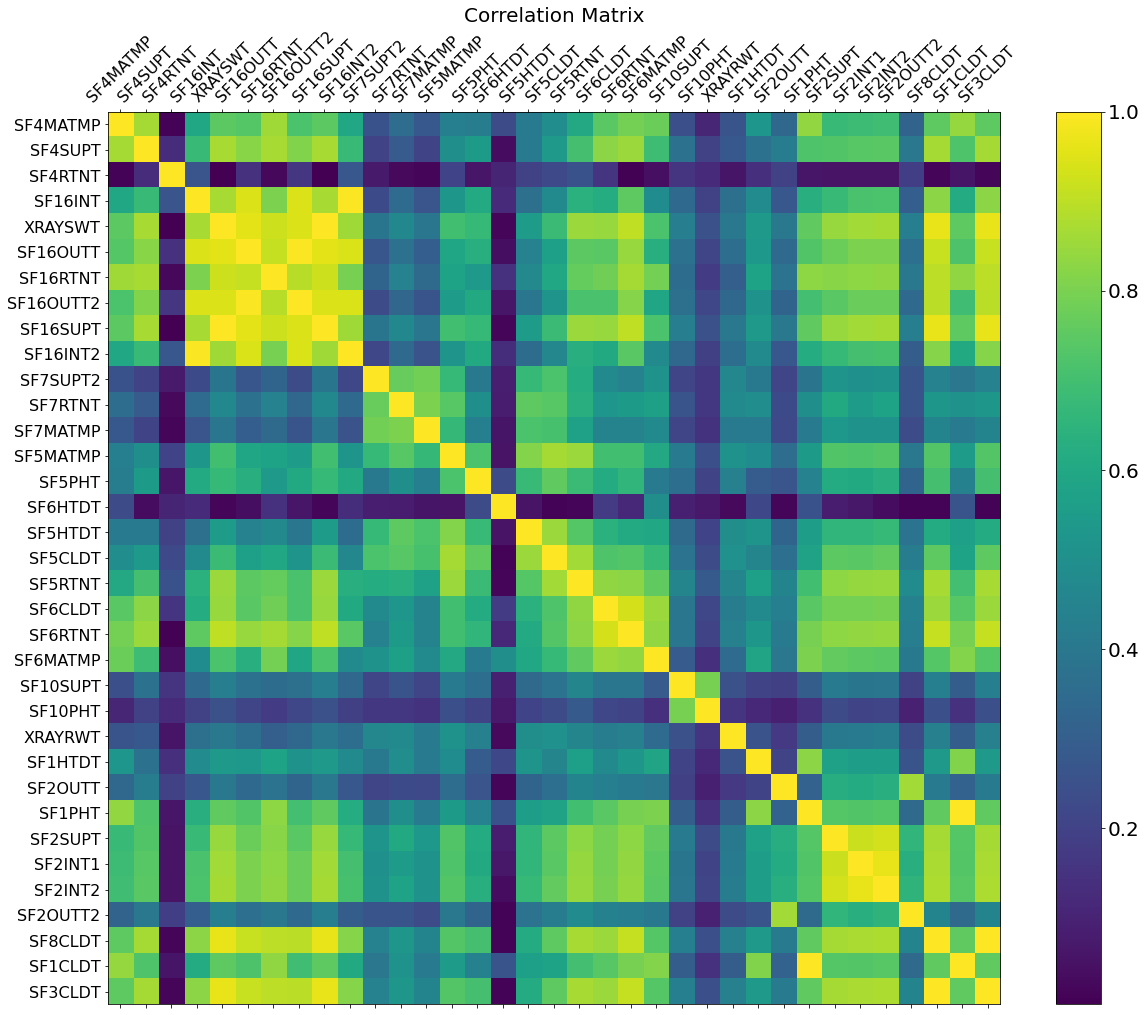

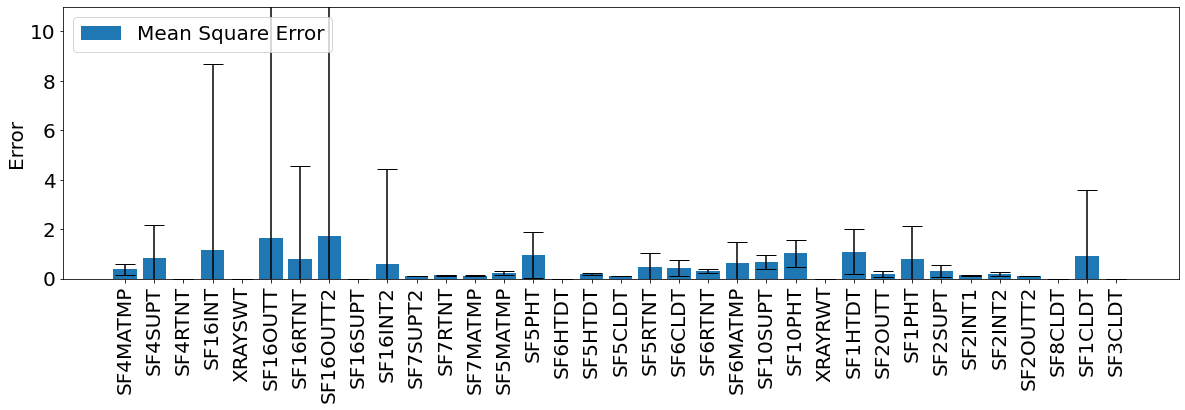

overall avg mse= 0.5045429233168879 overall avg cov= 1.7011205115744363


In [15]:

# Calculate Errors (mean and variances)
mean_err = np.empty(len(df_use.columns)-1)
var_err = np.empty(len(df_use.columns)-1)

t0 = time.time()
heatmap, df_corr = setPCC(0.2)

t1 = time.time()
for i in range(len(df_use.columns)-1):
    error = forecastGP(i, heatmap, df_corr)
    error = abs(error)
    mean_err[i] = np.mean(error)
    var_err[i] = np.var(error)
#     cov_err[i] = np.mean(y_cov)

t2 = time.time()
print ('Processing time1: ', t1-t0)
print ('Processing time2: ', t2-t1)
print ('Processing time: ', t2-t0)

# plot
plt.figure(figsize=(20,5))

plt.bar(range(len(mean_err)), mean_err, yerr = var_err, capsize = 10)
plt.xticks(range(len(mean_err)), df_corr.columns, rotation='vertical', fontsize=20)
plt.yticks(fontsize=20)
# plt.xlim(-5.0, 5.0)
plt.ylim(0, 11.0)
plt.legend(['Mean Square Error'], fontsize=20, loc=2)
plt.ylabel('Error', fontsize=20)
# plt.grid()
plt.show()
m_err = mean_err[mean_err > 0]
v_err = var_err[var_err >0]
print('overall avg mse=', m_err.mean(), 'overall avg cov=', v_err.mean())
    

/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Lack of correlated data = 2


/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may

Lack of correlated data = 15
Lack of correlated data = 24


/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/jongjunPark/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may

Processing time1:  0.08222389221191406
Processing time2:  1071.8437943458557
Processing time:  1071.9260182380676


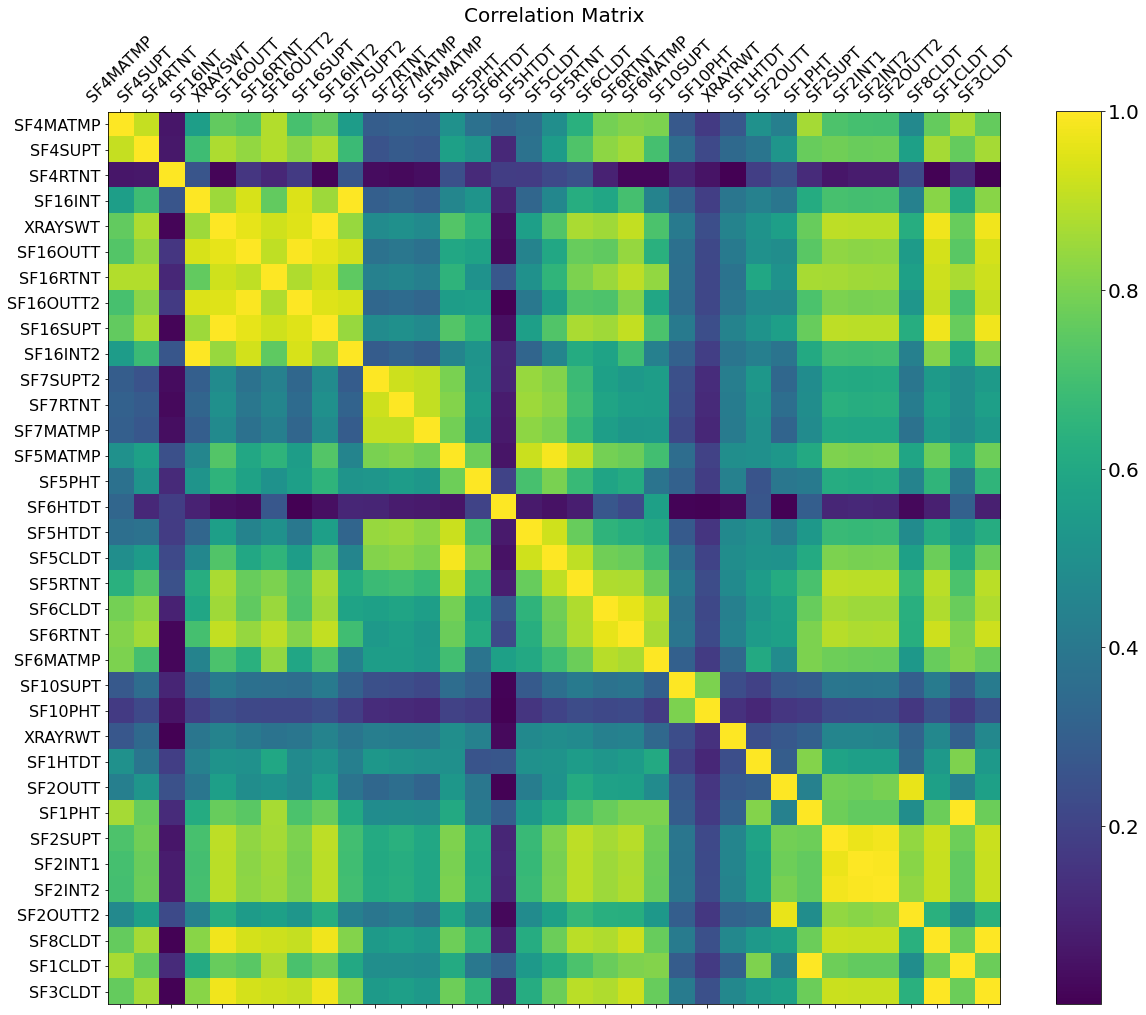

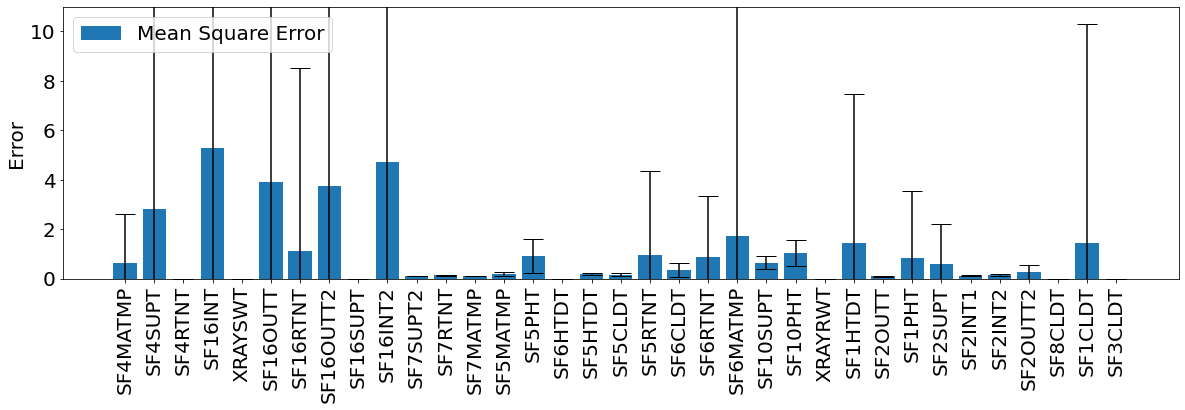

overall avg mse= 1.075419470446436 overall avg cov= 13.519089140930632


In [16]:
# For original data experiments

# Calculate Errors (mean and variances)
mean_err = np.empty(len(df_use.columns)-1)
var_err = np.empty(len(df_use.columns)-1)

t0 = time.time()
heatmap, df_corr = setPCC(0)

t1 = time.time()
for i in range(len(df_use.columns)-1):
    error = forecastGP(i, heatmap, df_corr)
    error = abs(error)
    mean_err[i] = np.mean(error)
    var_err[i] = np.var(error)
#     cov_err[i] = np.mean(y_cov)

t2 = time.time()
print ('Processing time1: ', t1-t0)
print ('Processing time2: ', t2-t1)
print ('Processing time: ', t2-t0)

# plot
plt.figure(figsize=(20,5))

plt.bar(range(len(mean_err)), mean_err, yerr = var_err, capsize = 10)
plt.xticks(range(len(mean_err)), df_corr.columns, rotation='vertical', fontsize=20)
plt.yticks(fontsize=20)
# plt.xlim(-5.0, 5.0)
plt.ylim(0, 11.0)
plt.legend(['Mean Square Error'], fontsize=20, loc=2)
plt.ylabel('Error', fontsize=20)
# plt.grid()
plt.show()
m_err = mean_err[mean_err > 0]
v_err = var_err[var_err >0]
print('overall avg mse=', m_err.mean(), 'overall avg cov=', v_err.mean())
    